### Full Name : Mohammad Morsali
### Student Number : 400101956


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [30]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def explore_data(data_loader):
    # Retrieve one batch of data
    sample_images, sample_labels = next(iter(data_loader))
    
    # Display 10 sample images with labels
    fig, axs = plt.subplots(1, 10, figsize=(15, 1.5))
    for idx, ax in enumerate(axs):
        ax.imshow(sample_images[idx].squeeze(), cmap='gray')
        ax.set_title(str(sample_labels[idx].item()))
        ax.axis('off')
    plt.show()
    
    # Collect all labels from the dataset
    label_list = []
    for _, labels_batch in data_loader:
        label_list.extend(labels_batch.numpy())
    label_array = np.array(label_list)
    
    # Plot label distribution
    plt.hist(label_array, bins=np.arange(label_array.min(), label_array.max()+2)-0.5, rwidth=0.8)
    plt.xticks(np.arange(label_array.min(), label_array.max()+1))
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title('Label Distribution')
    plt.show()
    
    # Display basic statistics
    total_samples = len(label_array)
    unique_classes = len(np.unique(label_array))
    print(f'Total samples: {total_samples}')
    print(f'Number of classes: {unique_classes}')
    
    # Count samples per class
    class_counts = np.bincount(label_array)
    for class_idx, count in enumerate(class_counts):
        print(f'Class {class_idx}: {count} samples')


In [31]:
# from torchvision import transforms
# from torchvision.datasets import MNIST
# from torch.utils.data import DataLoader

# # Define your transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     # Add other transformations if needed
# ])

# # Create your dataset with the transform
# train_dataset = MNIST(root='/kaggle/working/', train=True, download=True, transform=transform)
# val_dataset = MNIST(root='/kaggle/working/', train=False, download=True, transform=transform)
# test_dataset = MNIST(root='/kaggle/working/', train=False, download=True, transform=transform)

# # Create your DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


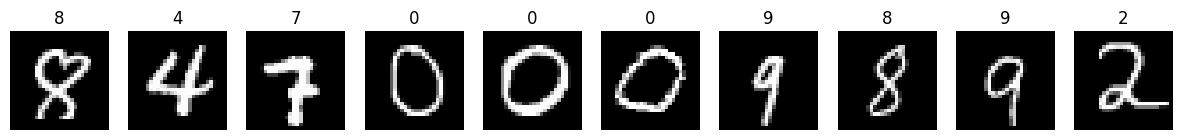

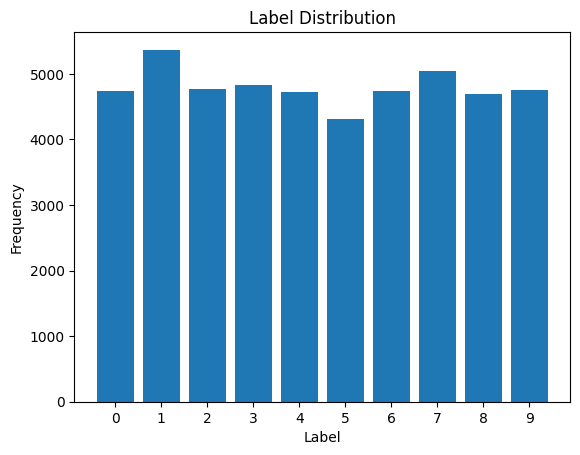

Total samples: 48000
Number of classes: 10
Class 0: 4747 samples
Class 1: 5369 samples
Class 2: 4772 samples
Class 3: 4837 samples
Class 4: 4717 samples
Class 5: 4318 samples
Class 6: 4738 samples
Class 7: 5046 samples
Class 8: 4700 samples
Class 9: 4756 samples


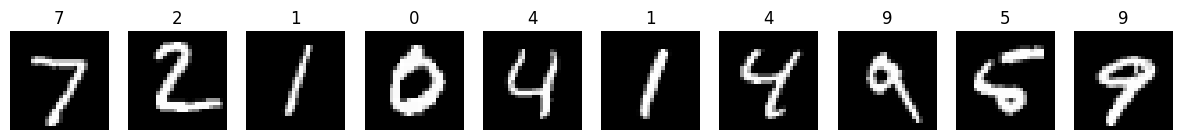

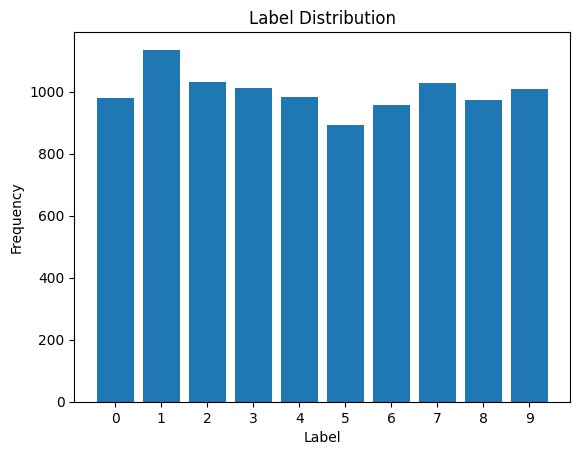

Total samples: 10000
Number of classes: 10
Class 0: 980 samples
Class 1: 1135 samples
Class 2: 1032 samples
Class 3: 1010 samples
Class 4: 982 samples
Class 5: 892 samples
Class 6: 958 samples
Class 7: 1028 samples
Class 8: 974 samples
Class 9: 1009 samples


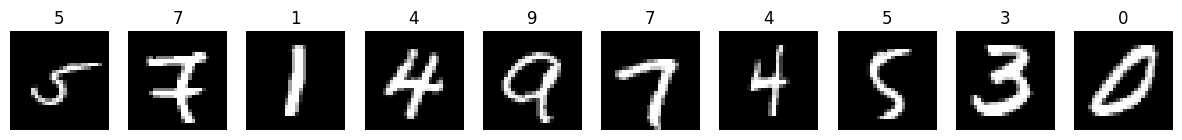

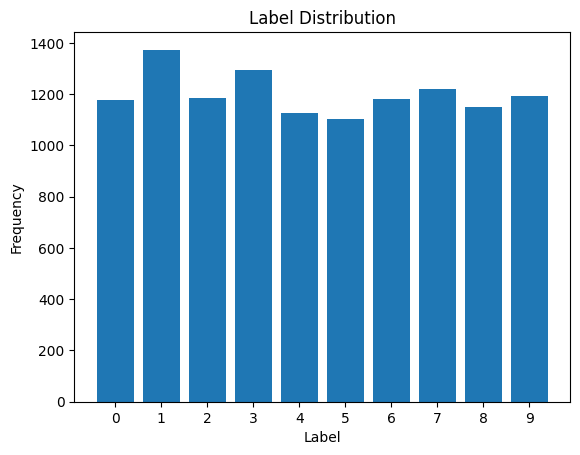

Total samples: 12000
Number of classes: 10
Class 0: 1176 samples
Class 1: 1373 samples
Class 2: 1186 samples
Class 3: 1294 samples
Class 4: 1125 samples
Class 5: 1103 samples
Class 6: 1180 samples
Class 7: 1219 samples
Class 8: 1151 samples
Class 9: 1193 samples


In [32]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [33]:
def prepare_data_for_cart(data_loader):
    """
    Prepares the dataset from a DataLoader for use with CART models by flattening images and collecting labels.

    Args:
        data_loader (torch.utils.data.DataLoader): DataLoader yielding batches of images and labels.

    Returns:
        X (np.ndarray): Feature matrix of shape (num_samples, num_features).
        y (np.ndarray): Label vector of shape (num_samples,).
    """
    feature_list, label_list = [], []
    
    for batch_idx, (image_batch, label_batch) in enumerate(data_loader):
        # Ensure tensors are on CPU
        image_batch = image_batch.cpu()
        label_batch = label_batch.cpu()
        
        # Flatten images to (batch_size, num_features)
        batch_size = image_batch.size(0)
        num_features = image_batch.size(1) * image_batch.size(2) * image_batch.size(3)
        images_flat = image_batch.view(batch_size, -1).numpy()
        
        # Convert labels to numpy arrays
        labels_np = label_batch.numpy()
        
        # Append to lists
        feature_list.append(images_flat)
        label_list.append(labels_np)
        

       # print(f'Processed batch {batch_idx + 1}/{len(data_loader)}')
    
    # Concatenate all batches
    X = np.vstack(feature_list)
    y = np.concatenate(label_list)
    
    # Print final dataset shape
    print(f'Final dataset shape: Features {X.shape}, Labels {y.shape}')
    
    return X, y


In [34]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

Final dataset shape: Features (48000, 784), Labels (48000,)
Final dataset shape: Features (12000, 784), Labels (12000,)
Final dataset shape: Features (10000, 784), Labels (10000,)


## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

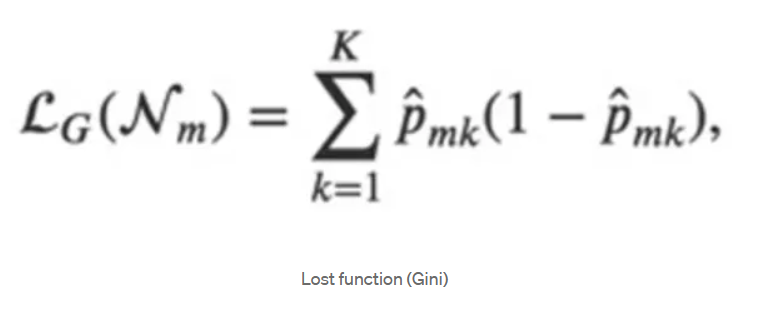

# I Improved and comleted the classes 

In [35]:
import numpy as np
from joblib import Parallel, delayed

class TreeNode:
    def __init__(self, feature_index=None, split_value=None, left_child=None, right_child=None, label=None):
        self.feature_index = feature_index
        self.split_value = split_value
        self.left_child = left_child
        self.right_child = right_child
        self.label = label

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, current_depth=0):
        # Stopping criteria
        if len(np.unique(y)) == 1:
            return TreeNode(label=y[0])

        if current_depth >= self.max_depth or len(y) < self.min_samples_split:
            majority_label = np.bincount(y).argmax()
            return TreeNode(label=majority_label)

        # Find the best split
        best_feature_idx, best_split_value = self._determine_best_split(X, y)
        if best_feature_idx is None:
            majority_label = np.bincount(y).argmax()
            return TreeNode(label=majority_label)

        left_indices = X[:, best_feature_idx] <= best_split_value
        right_indices = X[:, best_feature_idx] > best_split_value

        if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
            majority_label = np.bincount(y).argmax()
            return TreeNode(label=majority_label)

        left_subtree = self._grow_tree(X[left_indices], y[left_indices], current_depth + 1)
        right_subtree = self._grow_tree(X[right_indices], y[right_indices], current_depth + 1)

        return TreeNode(feature_index=best_feature_idx, split_value=best_split_value,
                        left_child=left_subtree, right_child=right_subtree)

    def _determine_best_split(self, X, y):
        n_samples, n_features = X.shape

        def evaluate_feature_split(feature_idx):
            unique_values = np.unique(X[:, feature_idx])
            best_split_value = None
            lowest_impurity = float('inf')
            for value in unique_values:
                left_indices = X[:, feature_idx] <= value
                right_indices = X[:, feature_idx] > value

                if len(np.unique(y[left_indices])) == 1 or len(np.unique(y[right_indices])) == 1:
                    continue

                impurity_left = self._compute_gini(y[left_indices])
                impurity_right = self._compute_gini(y[right_indices])
                total_impurity = (len(y[left_indices]) * impurity_left + len(y[right_indices]) * impurity_right) / len(y)

                if total_impurity < lowest_impurity:
                    lowest_impurity = total_impurity
                    best_split_value = value

            return feature_idx, best_split_value, lowest_impurity

        # Parallelize over all features using joblib
        results = Parallel(n_jobs=-1)(delayed(evaluate_feature_split)(idx) for idx in range(n_features))

        # Select the best result
        best_feature_idx, best_split_value, lowest_impurity = min(results, key=lambda x: x[2], default=(None, None, float('inf')))
        if lowest_impurity == float('inf'):
            return None, None

        return best_feature_idx, best_split_value

    def _compute_gini(self, y):
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        impurity = 1 - np.sum(probabilities ** 2)
        return impurity

    def predict(self, X):
        return np.array([self._predict_sample(sample, self.root) for sample in X])

    def _predict_sample(self, sample, node):
        if node.label is not None:
            return node.label
        if sample[node.feature_index] <= node.split_value:
            return self._predict_sample(sample, node.left_child)
        else:
            return self._predict_sample(sample, node.right_child)


## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.


Training with tree depth: 1
Our CART Implementation - Accuracy: 0.1925, Time: 27.11s
Scikit-Learn DecisionTree - Accuracy: 0.1925, Time: 0.19s

Training with tree depth: 4
Our CART Implementation - Accuracy: 0.5760, Time: 121.89s
Scikit-Learn DecisionTree - Accuracy: 0.5760, Time: 0.58s

Training with tree depth: 7
Our CART Implementation - Accuracy: 0.7545, Time: 245.88s
Scikit-Learn DecisionTree - Accuracy: 0.7585, Time: 0.98s

Training with tree depth: 10
Our CART Implementation - Accuracy: 0.8040, Time: 538.63s
Scikit-Learn DecisionTree - Accuracy: 0.8065, Time: 1.36s

Training with tree depth: 13
Our CART Implementation - Accuracy: 0.8105, Time: 758.48s
Scikit-Learn DecisionTree - Accuracy: 0.8100, Time: 1.61s

Training with tree depth: 15
Our CART Implementation - Accuracy: 0.8100, Time: 810.83s
Scikit-Learn DecisionTree - Accuracy: 0.8085, Time: 1.77s

Training with tree depth: 17
Our CART Implementation - Accuracy: 0.8100, Time: 827.93s
Scikit-Learn DecisionTree - Accuracy: 0.

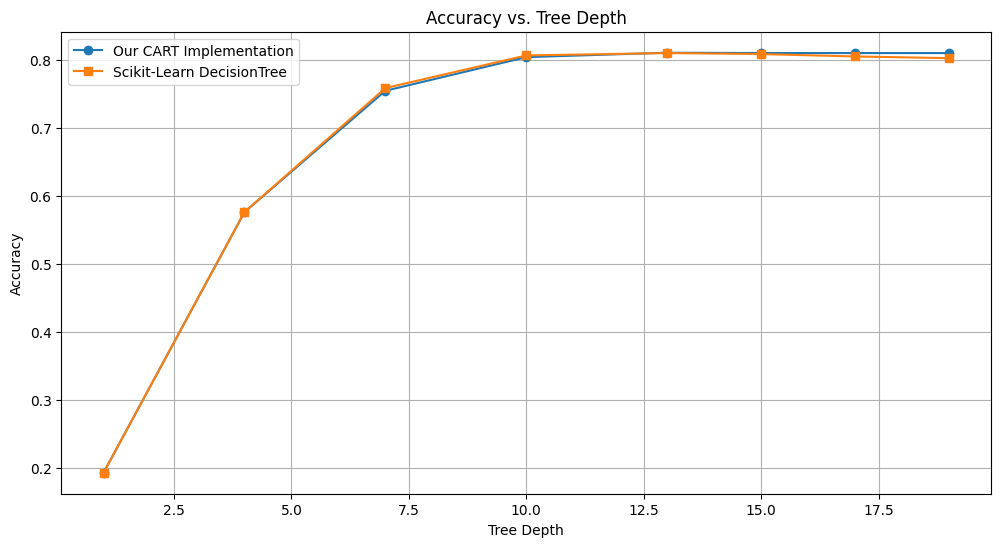

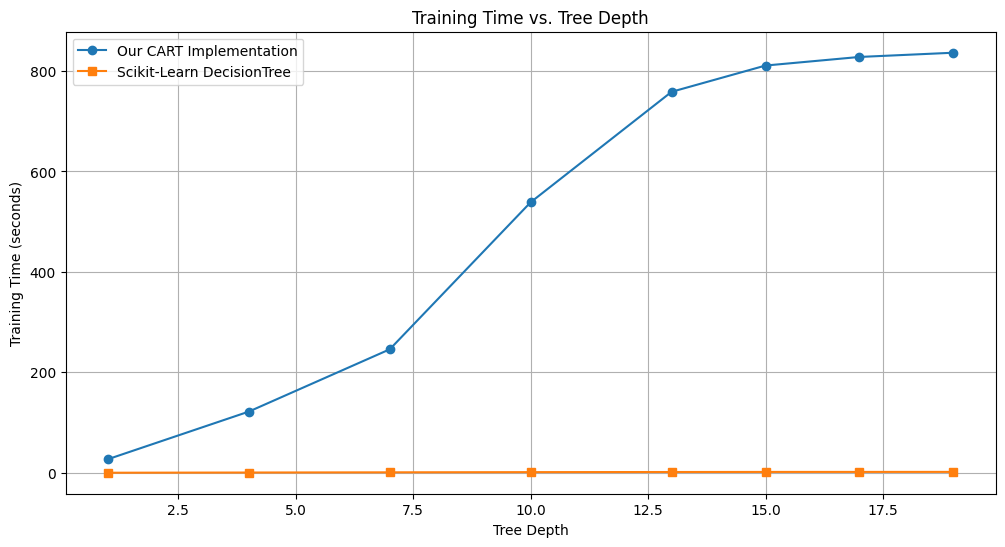

In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

sample_size_train = 10000
sample_size_test = 2000

indices_train = np.random.choice(len(X_train), sample_size_train, replace=False)
X_train_sample = X_train[indices_train]
y_train_sample = y_train[indices_train]

indices_test = np.random.choice(len(X_test), sample_size_test, replace=False)
X_test_sample = X_test[indices_test]
y_test_sample = y_test[indices_test]

# Initialize lists
depths =  [1, 4, 7, 10, 13,15,17,19]
accuracies_cart = []
accuracies_sklearn = []
times_cart = []
times_sklearn = []

for depth in depths:
    print(f"\nTraining with tree depth: {depth}")
    
    # Our CART implementation
    start_time = time.time()
    cart_tree = DecisionTree_CART(max_depth=depth, min_samples_split=2)
    cart_tree.fit(X_train_sample, y_train_sample)
    cart_time = time.time() - start_time
    times_cart.append(cart_time)
    
    y_pred_cart = cart_tree.predict(X_test_sample)
    acc_cart = accuracy_score(y_test_sample, y_pred_cart)
    accuracies_cart.append(acc_cart)
    print(f"Our CART Implementation - Accuracy: {acc_cart:.4f}, Time: {cart_time:.2f}s")
    
    # Scikit-Learn's implementation
    start_time = time.time()
    sklearn_tree = DecisionTreeClassifier(max_depth=depth)
    sklearn_tree.fit(X_train_sample, y_train_sample)
    sklearn_time = time.time() - start_time
    times_sklearn.append(sklearn_time)
    
    y_pred_sklearn = sklearn_tree.predict(X_test_sample)
    acc_sklearn = accuracy_score(y_test_sample, y_pred_sklearn)
    accuracies_sklearn.append(acc_sklearn)
    print(f"Scikit-Learn DecisionTree - Accuracy: {acc_sklearn:.4f}, Time: {sklearn_time:.2f}s")

# Plot Accuracy vs. Tree Depth
plt.figure(figsize=(12, 6))
plt.plot(depths, accuracies_cart, marker='o', label='Our CART Implementation')
plt.plot(depths, accuracies_sklearn, marker='s', label='Scikit-Learn DecisionTree')
plt.title('Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Plot Training Time vs. Tree Depth
plt.figure(figsize=(12, 6))
plt.plot(depths, times_cart, marker='o', label='Our CART Implementation')
plt.plot(depths, times_sklearn, marker='s', label='Scikit-Learn DecisionTree')
plt.title('Training Time vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Training Time (seconds)')
plt.grid(True)
plt.legend()
plt.show()


## Question
What is the difference between ID3 and CART algorithm

### Difference Between ID3 and CART Algorithms

**ID3 (Iterative Dichotomiser 3)** and **CART (Classification and Regression Trees)** are both decision tree algorithms used for supervised learning tasks. However, they differ in key aspects:

1. **Type of Trees:**
   - **ID3** is mainly used for **classification** tasks. It generates a **classification tree** where each leaf represents a class label, and branches represent conjunctions of features leading to those class labels.
   - **CART** is more versatile. It can handle both **classification** and **regression** problems. When used for classification, CART produces a **classification tree**, and for regression, it creates a **regression tree**.

2. **Splitting Criterion:**
   - **ID3** uses **information gain** based on **entropy** to decide the feature that best splits the data at each node.
   - **CART** uses either **Gini impurity** for classification or **variance reduction** (or mean squared error) for regression. For classification tasks, Gini impurity is favored, which measures how often a randomly chosen element would be incorrectly labeled if randomly labeled according to the distribution of labels in the node.

3. **Handling Continuous Data:**
   - **ID3** typically works with categorical data. Handling continuous data in ID3 requires discretization before it can be used for splitting.
   - **CART** can naturally handle both continuous and categorical data. For continuous variables, it finds the optimal splitting point by considering all possible thresholds and chooses the one that minimizes the impurity.

4. **Tree Structure:**
   - **ID3** produces **multi-way splits**, meaning it can split a node into more than two branches depending on the number of categories of the chosen attribute.
   - **CART** always produces **binary splits** (each node is split into two branches). Even if the dataset has categorical variables with more than two categories, CART will split them into two groups.

5. **Pruning:**
   - **ID3** does not include pruning by default. Pruning is a post-processing step added later to avoid overfitting in some implementations of ID3.
   - **CART** comes with built-in pruning mechanisms (either pre-pruning or post-pruning) to avoid overfitting by limiting tree growth.

6. **Output:**
   - **ID3** provides a decision tree where leaves correspond to discrete class labels.
   - **CART** can output a class label (classification) or a continuous value (regression).

7. **Mathematical Basis:**
   - **ID3** is based on information theory, particularly using entropy and information gain.
   - **CART** relies on the **Gini index** for classification and **mean squared error** for regression, which are both simpler and computationally efficient compared to entropy.

### Summary of Key Differences

| Feature              | ID3                                | CART                                |
|----------------------|------------------------------------|-------------------------------------|
| Task                 | Classification                     | Classification and Regression       |
| Splitting Criterion  | Information Gain (Entropy)         | Gini Index (Classification), MSE (Regression) |
| Split Type           | Multi-way                          | Binary                             |
| Handles Continuous Data | No (requires discretization)      | Yes                                |
| Pruning              | Not included by default            | Built-in pruning (pre and post)     |
| Output               | Class labels                       | Class labels (classification), Continuous values (regression) |

In summary, **ID3** is more limited and less flexible compared to **CART**, which can handle both classification and regression tasks, continuous and categorical variables, and has built-in pruning capabilities.